In [1]:
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from scipy.stats import randint as sp_randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2

# Load data
df = pd.read_excel("PM25Bergen.xlsx")

# Temporal feature processing
df['Time'] = pd.to_datetime(df['Time'], format='%d.%m.%Y')
df['Year'] = df['Time'].dt.year
df['Month'] = df['Time'].dt.month
df['Day'] = df['Time'].dt.day
df = df.sort_values(by='Time')

# Extract features and target variable
X = df[["TV", "Tmean", "HDD", "VP", "WS", "WG", "meanRH", "SD", "PP", "Year", "Month","Day"]]
y = df["PM25"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



# Define ODE function
def ode_function(TV, Tmean, HDD, VP, WS, WG, meanRH, SD, PP):
    pass

# Custom layer to incorporate ODE function
class ODELayer(tf.keras.layers.Layer):
    def __init__(self, ode_function, **kwargs):
        super(ODELayer, self).__init__(**kwargs)
        self.ode_function = ode_function

    def call(self, inputs):
        # Apply the ODE function
        return self.ode_function(*inputs)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]  # Output shape same as input shape except the last dimension
    

# Physical based deep learning model with ODE
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=100, kernel_initializer="he_normal", activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=100, kernel_initializer="he_normal", activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    ODELayer(output_dim=1),
])  
    
# Define ode system
def ode_system(y_true, y_pred):
    loss = tf.reduce_mean(tf.square(y_true - y_pred))  # Example: Mean Squared Error
    return loss

# Define custom estimator class
class CustomEstimator(BaseEstimator):
    def __init__(self, learning_rate, num_units, num_layers, kernel_regularizer=None):
        self.learning_rate = learning_rate
        self.num_units = num_units
        self.num_layers = num_layers
        self.kernel_regularizer = kernel_regularizer

        
    def fit(self, X, y):
        model = Sequential()
        model.add(Dense(units=self.num_units, kernel_initializer="he_normal", input_shape=(12,), kernel_regularizer=self.kernel_regularizer))
        model.add(BatchNormalization())
        model.add(Activation("elu"))
        for _ in range(self.num_layers - 1):
            model.add(Dense(units=self.num_units, kernel_initializer="he_normal", kernel_regularizer=self.kernel_regularizer))
            model.add(BatchNormalization())
            model.add(Activation("elu"))
        model.add(Dense(units=1))
        optimizer = tf.keras.optimizers.Nadam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss=ode_system, metrics=['mse'])
        self.model = model
        self.history = self.model.fit(X, y, epochs=1000, batch_size=32, verbose=0)
        return self


# Define hyperparameters for random search
param_dist = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01],
    'num_units': sp_randint(50, 200),
    'num_layers': sp_randint(1, 4),
    'kernel_regularizer': [None, l2(0.01), l2(0.001)]
}

# Create an instance of CustomEstimator
custom_estimator_instance = CustomEstimator(learning_rate=0.001, num_units=100, num_layers=2)

# Define custom scorer
def custom_scorer(estimator, X, y):
    return -estimator.model.evaluate(X, y, verbose=0)[0]  # Return negative validation loss

# Create and fit RandomizedSearchCV with the instance of CustomEstimator
random_search = RandomizedSearchCV(estimator=custom_estimator_instance, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, scoring=custom_scorer)
random_search_result = random_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters: ", random_search_result.best_params_)
print("Best Score: ", random_search_result.best_score_)

# Access the best model from the RandomizedSearchCV
best_model = random_search.best_estimator_.model

# Train the model with best parameters
history = best_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), verbose=1)




KeyboardInterrupt: 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


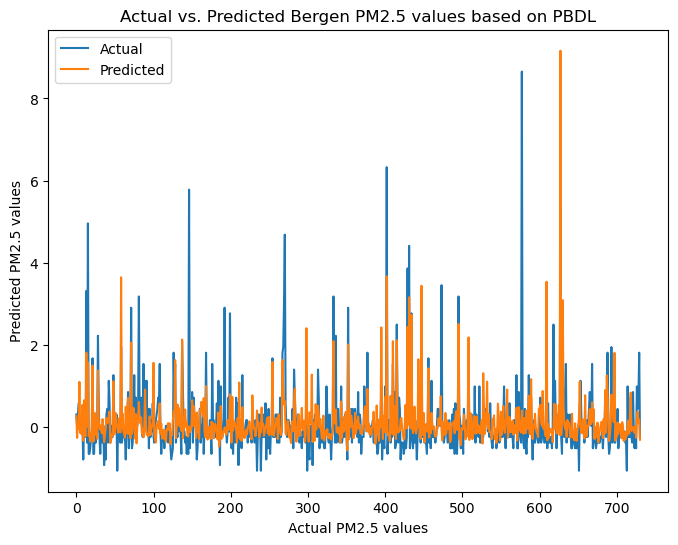

In [2]:
# Make predictions on the validation set

y_pred = model.predict(X_val)


# Plot predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.plot(y_val, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Actual PM2.5 values')
plt.ylabel('Predicted PM2.5 values')
plt.title('Actual vs. Predicted Bergen PM2.5 values based on PBDL')
plt.legend()
plt.show()





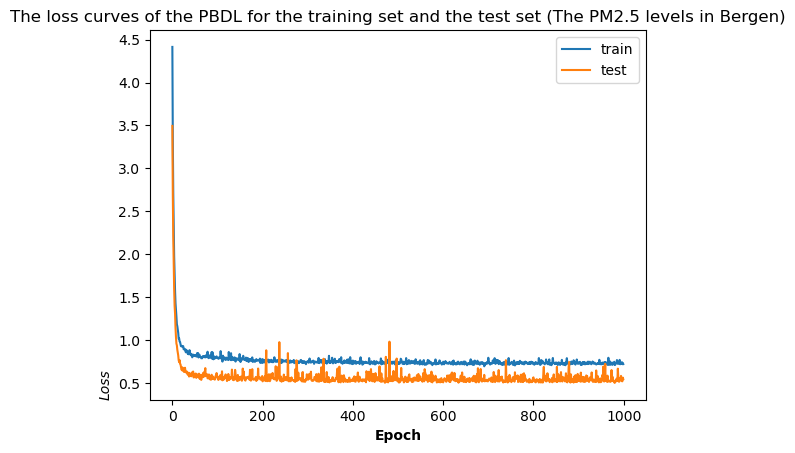

In [3]:
# 对损失进行可视化
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('The loss curves of the PBDL for the training set and the test set (The PM2.5 levels in Bergen)')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', style='italic', loc='bottom')
plt.legend()
plt.show()

In [4]:


from sklearn.metrics import mean_squared_error

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Calculate Mean Squared Error
mse = mean_squared_error(y_val, y_pred)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Root Mean Squared Error (RMSE): 0.7200794303460976
